In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
import torch
import torch.nn as nn
import torch.utils 
from torch.nn import Sigmoid
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#Loading in the data
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),])

kwargs = {'num_workers': 1, 'pin_memory': True} 


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_data = torch.utils.data.Subset(train_dataset, range(0,50000))
val_data = torch.utils.data.Subset(train_dataset, range(50000, 60000))

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, **kwargs)
vali_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [4]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()
    def forward(self,x):
        return x[:, :, :28, :28]


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 2)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 2),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(2, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var


In [6]:
vae = VAE().to(device)
def loss_function(x, x_reconstr, mu_z, var_z):

    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    d2 = (x_reconstr[:,:1,:,:]-x)**2
    var = x_reconstr[:,1:,:,:]
    e = 1e-5
    var = torch.tensor([0.5]).to(device)
    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [7]:
epochs = 5

print("Start training VAE...")
start_time = time.time()
vae.train()

train_ELBO = []
validation_ELBO = []

for epoch in range(epochs):
    
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()
        x = x.to(device)
        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    n_datapoints = batch_idx * batch_size
    train_ELBO.append((-overall_reconstr_loss + overall_kl_loss)/n_datapoints)
    
    with torch.no_grad():
        validation_loss = 0
        validation_reconstr_loss = 0
        validation_kl_loss = 0
        for batch_idx, (x, y) in enumerate(vali_loader):
            x = x.to(device)
            y = y.to(device)
            x_reconstr, mu, log_sigma = vae(x)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
            
            validation_loss += loss.item()
            validation_reconstr_loss += reconstr_loss.item()
            validation_kl_loss += kl_loss.item()
            
        n_datapoints = batch_idx * batch_size
        validation_ELBO.append((-validation_reconstr_loss + validation_kl_loss)/n_datapoints)
            
    if (np.absolute(train_ELBO[epoch] - train_ELBO[epoch-1]) <= 0.1) and (epoch != 0):
        print(train_ELBO)
        break
        
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")
print(start_time - time.time())

Start training VAE...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Using a target size (torch.Size([100, 1, 28, 28])) that is different to the input size (torch.Size([100, 2, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  after removing the cwd from sys.path.


	Epoch 1 	Average Loss:  538.1473809382892 	Reconstruction Loss: 516.8782830748895 	KL Loss: 21.26909799479475
	Epoch 2 	Average Loss:  399.62567698469064 	Reconstruction Loss: 376.07814921677715 	KL Loss: 23.547527844978102
	Epoch 3 	Average Loss:  384.0190969756155 	Reconstruction Loss: 358.83603535353535 	KL Loss: 25.183061307656644
	Epoch 4 	Average Loss:  376.2126860894097 	Reconstruction Loss: 350.2525647589173 	KL Loss: 25.96012106539023
	Epoch 5 	Average Loss:  371.0704131155303 	Reconstruction Loss: 344.6286737985322 	KL Loss: 26.441739178281843
Training complete!
-71.90316867828369


##3a

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 2)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 2),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(2, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [9]:
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_data = torch.utils.data.Subset(test_dataset, range(0,1000))
test_loader  = DataLoader(dataset=test_data,  batch_size=batch_size, shuffle=True,  **kwargs)
vae.eval()

x_list = []
y_list = []
x_reconstr_list = []
z_list = []
log_sigma_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        
        x_reconstr, z_mu, log_sigma = vae(x)
        x_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)
        z_list.append(z_mu)
        log_sigma_list.append(log_sigma)

100%|██████████| 10/10 [00:00<00:00, 39.07it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

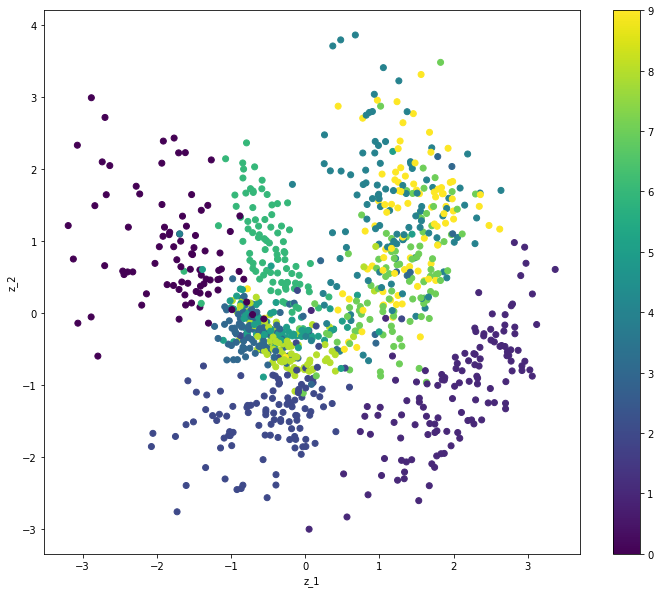

In [26]:
# Visualize latent space
plt.figure(figsize=(12, 10))
for z, y in zip(z_list, y_list):
    z = z.cpu().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y)
plt.colorbar()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.show()

###3b

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 10)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 10),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

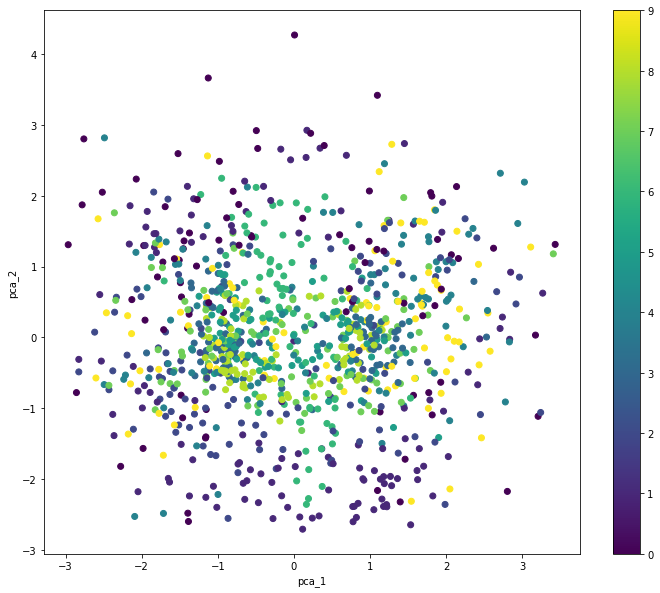

In [25]:
# Visualize latent space using PCA
pca = PCA()
plt.figure(figsize=(12, 10))
for z, y in zip(z_list, y_list):
    z = z.cpu().numpy()
    pca_feat = pca.fit_transform(z)
    plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c=y)
plt.colorbar()
plt.xlabel("pca_1")
plt.ylabel("pca_2") 
plt.show()

#3c

In [22]:
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_data = torch.utils.data.Subset(test_dataset, range(0,1000))
test_loader  = DataLoader(dataset=test_data,  batch_size=batch_size, shuffle=True,  **kwargs)
x, labels = iter(test_loader).next()
# first encode data points
vae_encode = vae.encoder(x)

In [23]:
def interpolation(model, encoded, n = 10):
  plt.figure(figsize=(12, 5))
  x1 = encoded[0]
  x2 = encoded[1]
  y1 = labels[0].item()
  y2 = labels[1].item()
  # compute linear interpolation for data points
  for i in range(n + 1):
    k = i / n
    inter = ((1 - k) * x1 + k * x2)[:2]
    # decode data points after working in the latent space
    decoded = model.decoder(inter.unsqueeze(0)).squeeze().detach()
    plt.subplot(1, n + 1, i + 1)
    if i == 0:
      plt.title(y1)
    elif i == n:
      plt.title(y2)
    plt.axis('off')
    plt.imshow(decoded)
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

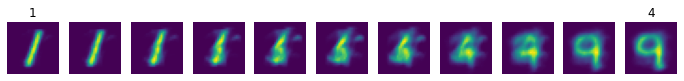

In [24]:
# visualize interpolation
interpolation(vae, vae_encode)